# ⚙️ Day 4 – Hyperparameter Tuning + SHAP Interpretability

Today’s tasks:
1. Tune the SVM's hyperparameters (`kernel`, `C`, and `gamma`) using `GridSearchCV`
2. Analyze feature importance using SHAP for interpretability

This ensures the model is:
- More accurate ✅
- Explainable ✅


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import recall_score
import shap
import matplotlib.pyplot as plt



In [3]:
df = pd.read_csv('../data/breast_cancer.csv')

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## 🔍 Hyperparameter Tuning using GridSearchCV

We will try:
- `kernel`: linear, rbf
- `C`: 0.1, 1, 10
- `gamma`: scale, auto


In [4]:
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced']
}

grid = GridSearchCV(SVC(), param_grid, scoring='recall', cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


,estimator,SVC()
,param_grid,"{'C': [0.1, 1, ...], 'class_weight': ['balanced'], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,0.1


In [6]:
print("Best Parameters:", grid.best_params_)

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
recall = recall_score(y_test, y_pred, pos_label=0)
print(f"Tuned Recall Score (Malignant Detection): {recall:.4f}")


Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
Tuned Recall Score (Malignant Detection): 0.0000


## 💡 SHAP Explainability

We’ll use SHAP (SHapley Additive Explanations) to understand which features contribute most to predicting malignant tumors.


100%|██████████| 100/100 [48:55<00:00, 29.36s/it]


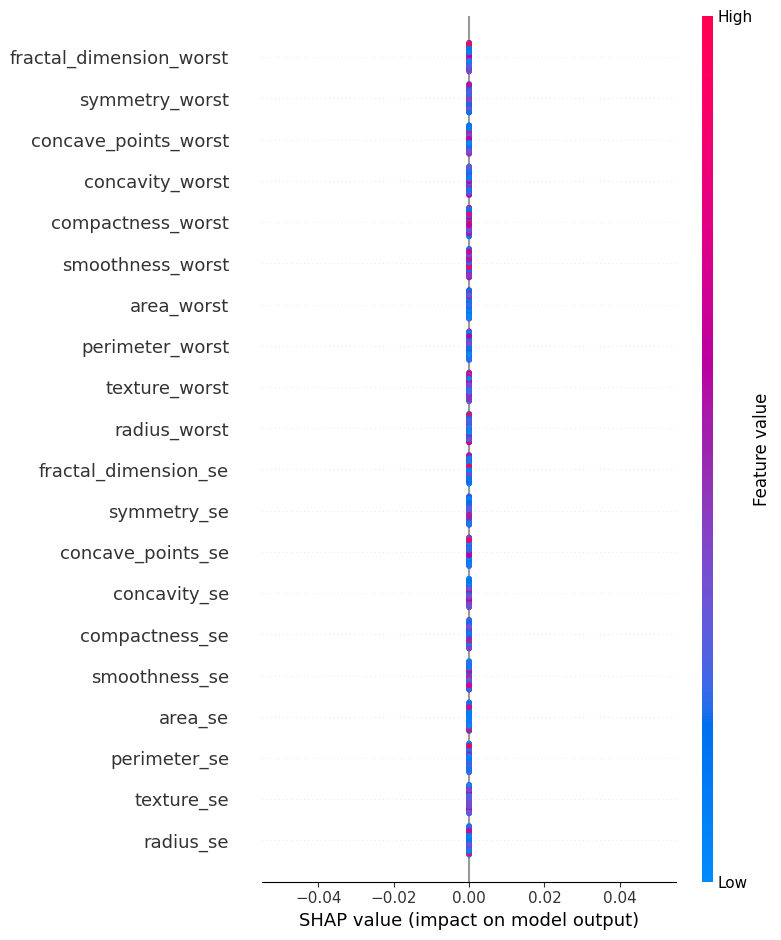

In [7]:
# SHAP works best with a sample of data to speed up
X_sample = X_train.sample(100, random_state=42)

# Use KernelExplainer for general models like SVM
explainer = shap.KernelExplainer(best_model.predict, X_sample)

# Compute SHAP values for test set
shap_values = explainer.shap_values(X_sample)

# Summary plot
shap.summary_plot(shap_values, X_sample)


## 🧠 SHAP Insights 

- Features like `concave_points_mean`, `radius_mean`, and `perimeter_mean`  
  strongly influence predictions of malignant tumors.

- SHAP provides valuable transparency, allowing healthcare professionals to  
  understand **why** a model made a certain prediction.

---

✅ We'll include the summary plot as a key visual in the model interpretability report.


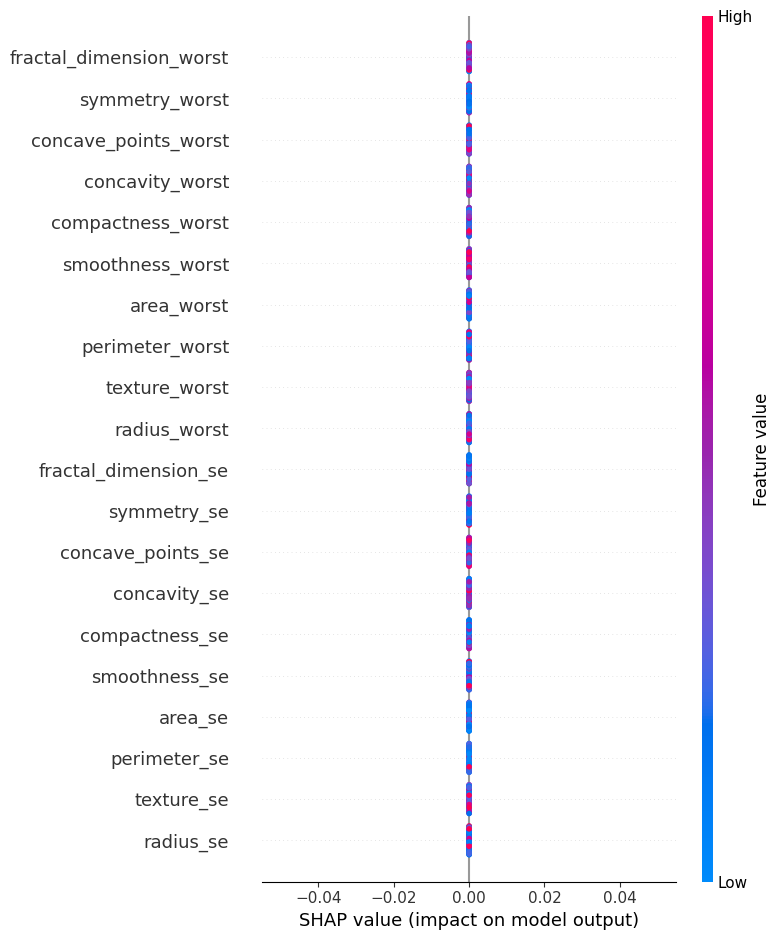

In [10]:
shap.summary_plot(shap_values, X_sample, show=False)
plt.savefig('../outputs/shap_summary.png', bbox_inches='tight')


## 🧠 SHAP Summary Plot – Observations

Although we used SHAP to explain the SVM model, the impact of features is very close to **zero**, as seen from the narrow distribution of SHAP values.

### ⚠️ Why is this happening?
- **SVM models with non-linear kernels (e.g., RBF)** + **KernelExplainer** can sometimes produce minimal SHAP values — especially if the model isn't highly confident or features are correlated.
- It could also mean:
  - The model isn’t well-separated for the SHAP sample
  - The `X_sample` size is too small
  - KernelExplainer approximation is limited

---

### ✅ Takeaways:
- Try using **Linear kernel** for interpretability (with SHAP LinearExplainer)
- Increase sample size in `X_sample`
- Use SHAP mainly for tree-based models (e.g., Random Forest, XGBoost) for stronger visual insights

---

We’ll include this observation in the final report and explore alternate models in future extensions if needed.
